In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "PlantVillage",
  shuffle=True,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [4]:
def prepare_data_set(data, training_size = 0.8, validing_size = 0.1, testing_size = 0.1, shuffle=True, shuffle_size=10000):
    #assume that all size partition is equal to one
    assert (training_size + validing_size + testing_size) == 1
    data_set_size = len(data)
    #reduce bias and improve generalization
    if shuffle:
        data = data.shuffle(shuffle_size, seed = 12)

    train_size = int(data_set_size * training_size)
    valid_size = int(data_set_size * validing_size)
    test_size = int(data_set_size * testing_size)

    train_ds = data.take(train_size)
    valid_ds = data.skip(train_size).take(valid_size)
    test_ds = data.skip(train_size).skip(valid_size)

    return train_ds, valid_ds, test_ds

In [5]:
train_ds, valid_ds, test_ds = prepare_data_set(dataset)

# Caching

In [6]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Resize the image to 256X256 and then scale them

In [7]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Data Augmentation

In [8]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# Creating training model

In [12]:
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

# Compile Model

In [13]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [14]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100
54/54 [==============================] - 35s 632ms/step - loss: 0.9589 - accuracy: 0.4612 - val_loss: 0.8584 - val_accuracy: 0.5156
Epoch 2/100
54/54 [==============================] - 34s 626ms/step - loss: 0.8829 - accuracy: 0.5139 - val_loss: 0.7373 - val_accuracy: 0.5833
Epoch 3/100
54/54 [==============================] - 34s 634ms/step - loss: 0.7579 - accuracy: 0.6325 - val_loss: 0.6385 - val_accuracy: 0.7240
Epoch 4/100
54/54 [==============================] - 34s 623ms/step - loss: 0.5685 - accuracy: 0.7569 - val_loss: 0.5105 - val_accuracy: 0.8229
Epoch 5/100
54/54 [==============================] - 34s 634ms/step - loss: 0.3919 - accuracy: 0.8490 - val_loss: 0.3188 - val_accuracy: 0.8698
Epoch 6/100
54/54 [==============================] - 34s 638ms/step - loss: 0.3092 - accuracy: 0.8692 - val_loss: 0.3922 - val_accuracy: 0.8438
Epoch 7/100
54/54 [==============================] - 34s 624ms/step - loss: 0.2830 - accuracy: 0.8866 - val_loss: 0.1664 - val_accuracy:

In [15]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 169ms/step - loss: 3.6229e-04 - accuracy: 1.0000


# Graph for the accuracy and loss

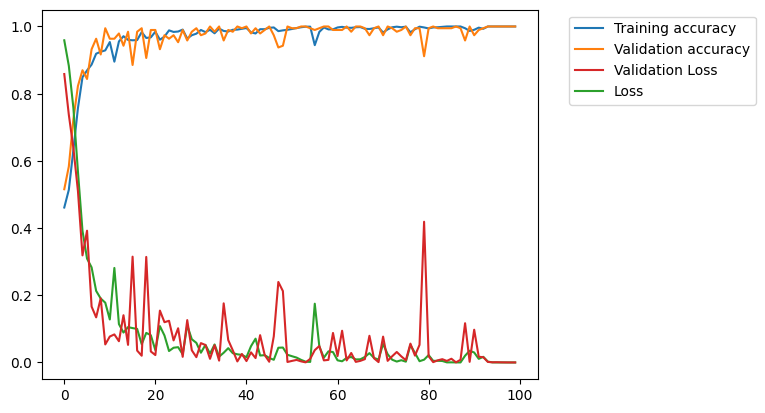

In [16]:
import matplotlib.pyplot as plt

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

fig, ax = plt.subplots()
line1, = ax.plot(training_accuracy, label='Training accuracy')
line2, = ax.plot(validation_accuracy, label='Validation accuracy')

line4, = ax.plot(training_loss, label='Loss')
line3, = ax.plot(validation_loss, label='Validation Loss')

ax.legend(bbox_to_anchor=(1.05, 1), handles=[line1, line2, line3, line4], loc='upper left')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 248ms/step
predicted label: Potato___Early_blight


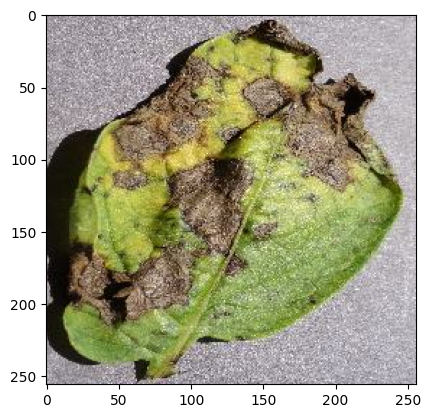

In [17]:
import numpy as np
class_names = dataset.class_names
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Save the model

In [20]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1/assets


INFO:tensorflow:Assets written to: ../models/1/assets


In [28]:
model.save("potato_predict_model.h5")